In [1]:
import sys
import os
sys.path.append('../')
sys.path.append('../modules/')
sys.path.append('../util/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import random
import models_Segmentation,models_Regression
from modeling.deeplab import *
from modeling.Unet_models import *
from util.metrics import *

## data visualization

In [2]:
IMAGEDIM = 224
TASK = 'Geobody'

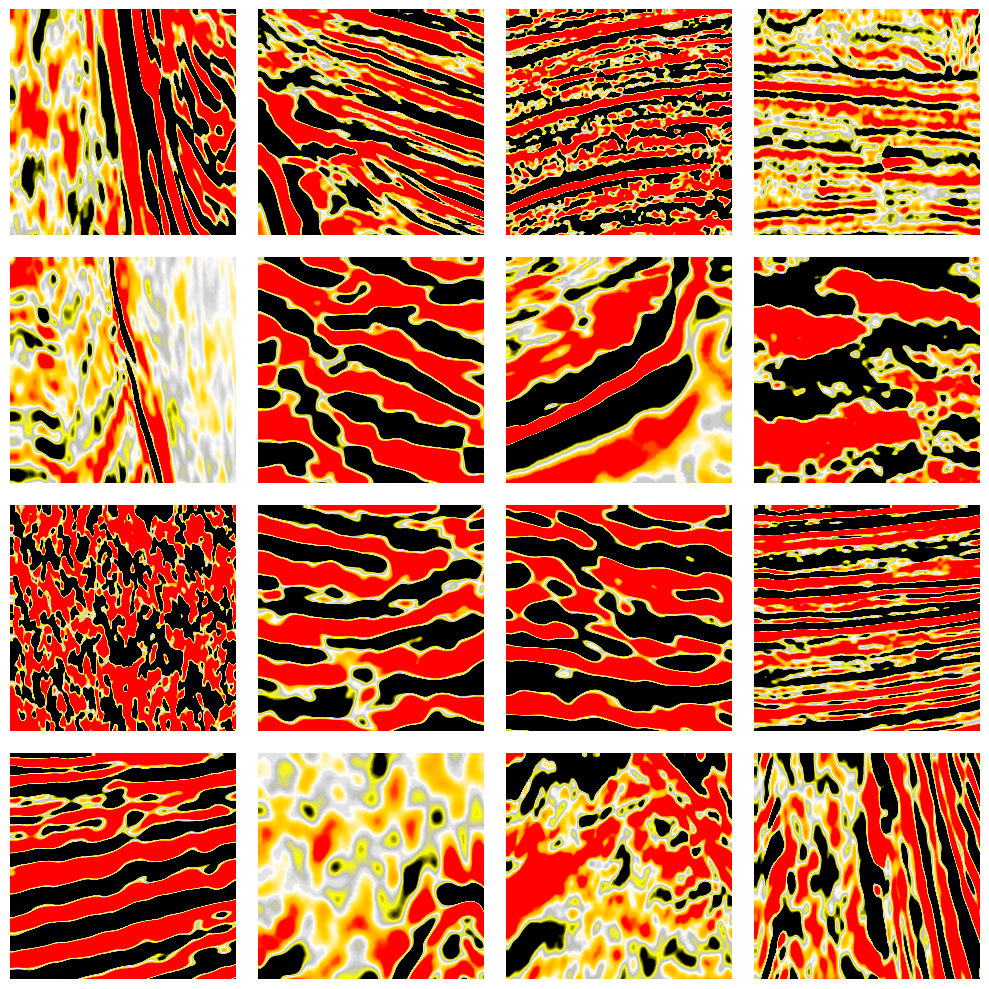

In [3]:
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)


data_path = '../../Data/Geobody/' +'seismic/'
label_path = '../../Data/Geobody/' +'label/'
data_files =  [str(f)+'.dat' for f in range(100,117)]
selected_files = random.sample(data_files, 16) # Random Select files to show


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    with open(os.path.join(data_path, selected_files[i]), 'rb') as f:
        
        data = np.fromfile(f, dtype=np.single)
        data = data.reshape((IMAGEDIM, IMAGEDIM))
        ax.imshow(data, cmap=cmap,vmin=np.min(data)/10,vmax=-np.min(data)/10)
        ax.axis('off')
# 显示整个图像
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

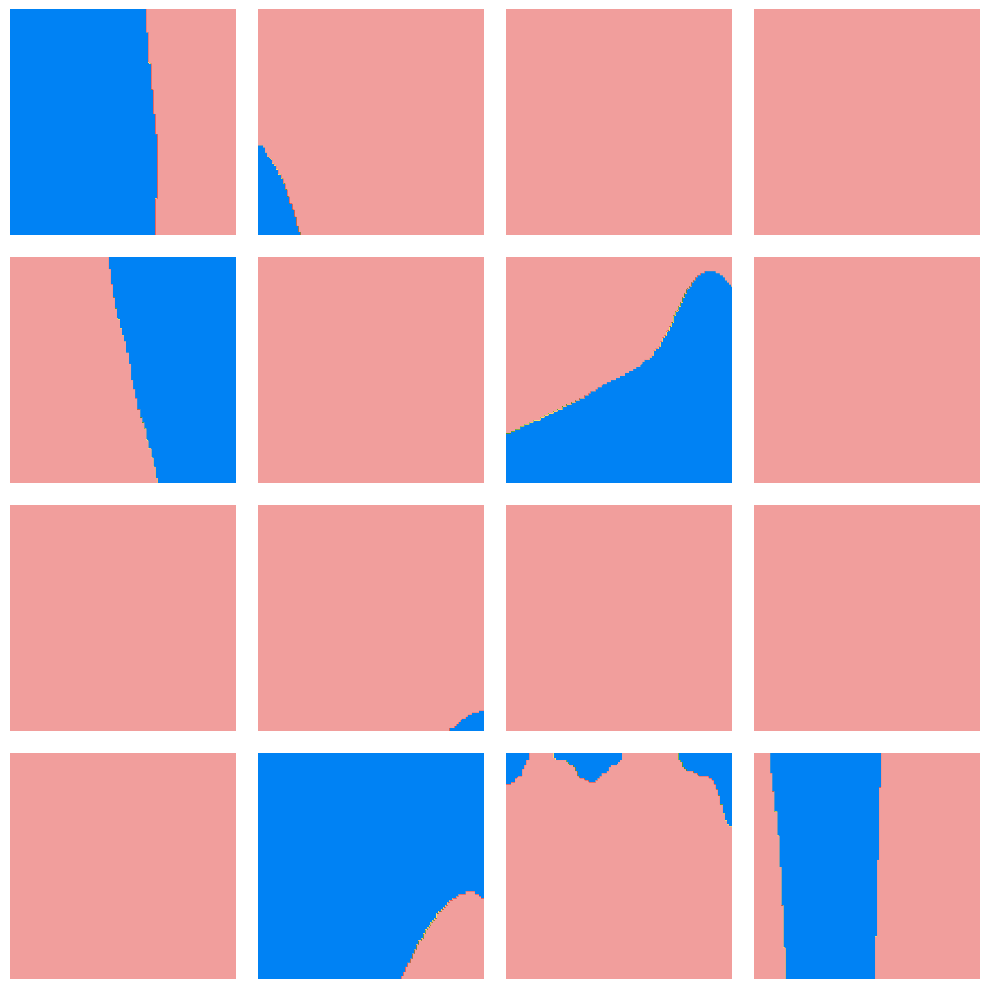

In [4]:
color_list = ['#F19E9C','#EB5C56','#43972B','#FEE76B','#F3B677','#0082F4'] #seam
cmapl = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    with open(os.path.join(label_path, selected_files[i]), 'rb') as f:
        data = np.fromfile(f, dtype=np.single)-1
        data = data.reshape((IMAGEDIM, IMAGEDIM))
        ax.imshow(data, cmap=cmapl)#,vmin=np.min(data)/2,vmax=-np.min(data)/2)
        ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Define utils

In [5]:
import matplotlib as mpl
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

def show_image(image, vmin=None, vmax=None, title='', figsize=None,cmap=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(image, cmap=cmap, interpolation='bicubic', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(image, interpolation='bicubic', vmin=vmin, vmax=vmax)
    plt.title(title)
#     plt.axis('off')
    # plt.show()
    return

## load Model

In [6]:
def prepare_model(chkpt_dir, arch='vit_large_patch16', img_size=IMAGEDIM):
    model = getattr(models_Segmentation, arch)(num_classes=2, 
                                      drop_path_rate=0.1, 
                                      in_chans=1, 
                                      img_size=img_size,
                                      global_pool=False,
                                      )
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
#     interpolate_pos_embed(model, checkpoint['model'])
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model 

In [13]:
#load model
chkpt_dir = '/usr/users/seismofoundation/ma_yuh/code/SFModel/SFM-Finetune/finetune_result/Salt/sert_Transformer_test/checkpoint-0.pth' 
model_SFM = prepare_model(chkpt_dir, 'vit_large_patch16', img_size=IMAGEDIM)


/tmp/ipykernel_1292719/153516162.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>


In [8]:
def run_one_image(img, model,l):
    x = torch.tensor(img)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    model_SFM.eval()
    pred = model_SFM(x)
    pred = pred.argmax(dim=1).detach().cpu()
    pred = pred.squeeze(0)
    pred = pred.squeeze(0)
    
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.subplot(1,3, 1)
    show_image(img, vmin=x.min()/12, vmax=x.max()/12, title="Seismic",cmap=cmap)
    
    plt.subplot(1,3, 2)
    show_image(l,cmap=cmapl, title="Label")
    
    plt.subplot(1,3, 3)
    show_image(pred,cmap=cmapl, title="SFM-Finetune Prediction")

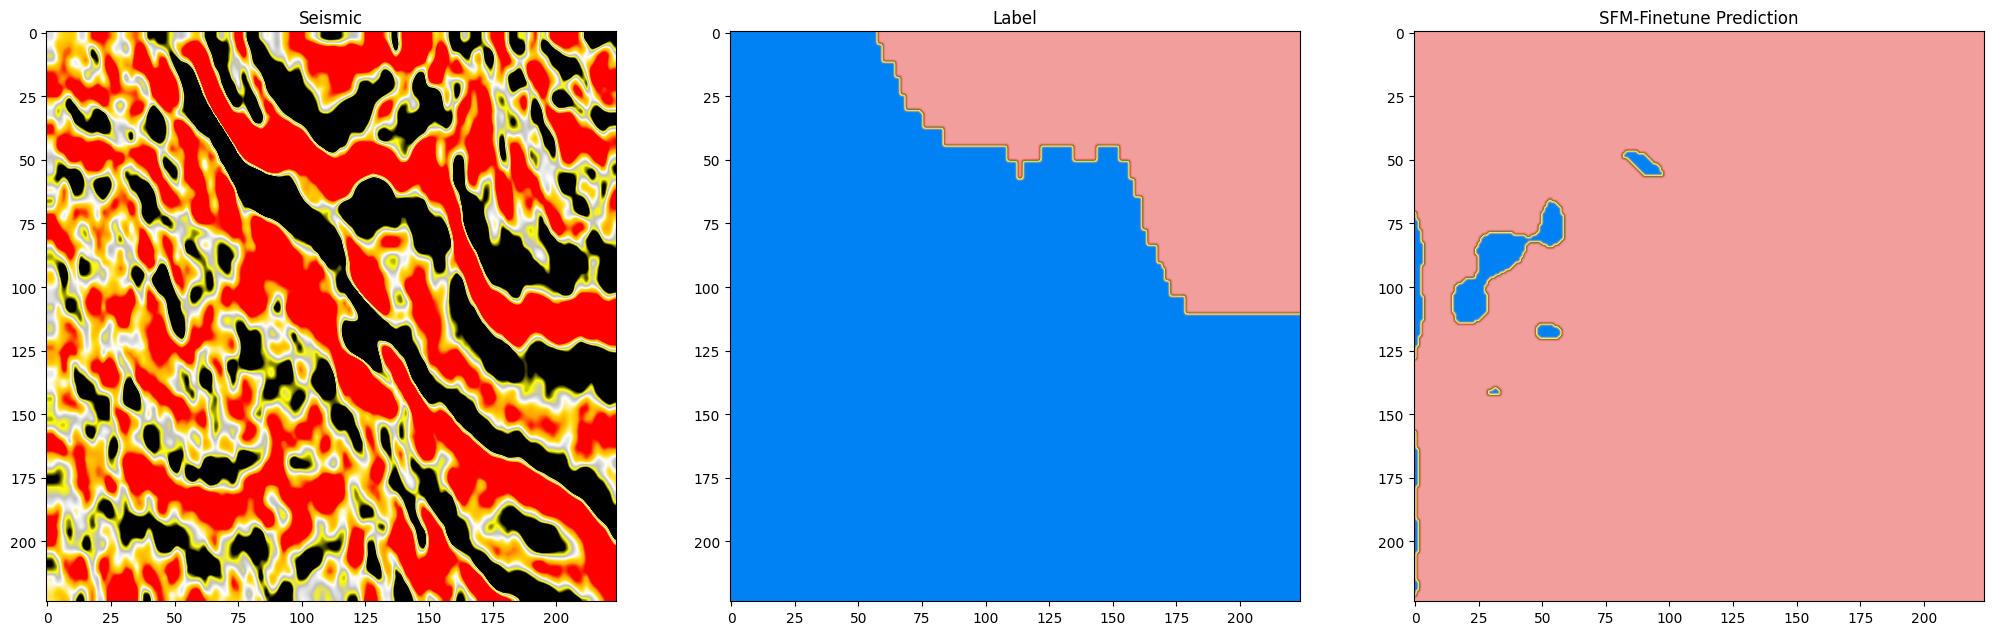

In [14]:
data_list = ['../../Data/Geobody/' +'seismic/'+ str(f)+'.dat' for f in range(117)]
label_list = [f.replace('/seismic/', '/label/') for f in data_list]

dnum = 101
 # we use 0-99 as the training dataset and 100-116 as the validation dataset
d = np.fromfile(data_list[dnum], np.float32)
d = d.reshape((IMAGEDIM,IMAGEDIM))
l = np.fromfile(label_list[dnum], np.float32).reshape([IMAGEDIM,IMAGEDIM])-1
l = l.astype(int)
run_one_image(d, model_SFM,l)

### Run index

In [9]:
def run_index(img, model, label=None, clims=None, savefig=None):
    model.eval()
    
    x = torch.tensor(img, dtype=torch.float32)
    pred  = model(x)
    pred  = pred.argmax(dim=1).detach().cpu()
    print(pred.shape)
    pred = pred.squeeze(0)
    return pred.numpy()

In [10]:
dd = np.zeros((5, 1, 768, 768))
predall = np.zeros((17, 768, 768)).astype('int64')

# loop through data
for j, start_idx in enumerate(range(100, 115, 5)):
    end_idx = start_idx + 5
    for i in range(start_idx, end_idx):
        d = np.fromfile(data_list[i], np.float32)
        d = d.reshape([1] + [768,768])
        dd[i-start_idx] = d
    # run prediction for current batch
    predall[j*5:j*5+5] = run_index(dd, model_SFM)#model_vit_finetune, model_vit_scartch,model_deeplab,model_unet

# last batch (only has 2 data samples)
dd = np.zeros((2, 1, 768, 768))
for i in range(115, 117):
    d = np.fromfile(data_list[i], np.float32)
    d = d.reshape([1] + [768,768])
    dd[i-115] = d
predall[15:17] = run_index(dd, model_SFM)#model_vit_finetune, model_vit_scartch,model_deeplab,model_unet


torch.Size([5, 768, 768])
torch.Size([5, 768, 768])
torch.Size([5, 768, 768])
torch.Size([2, 768, 768])


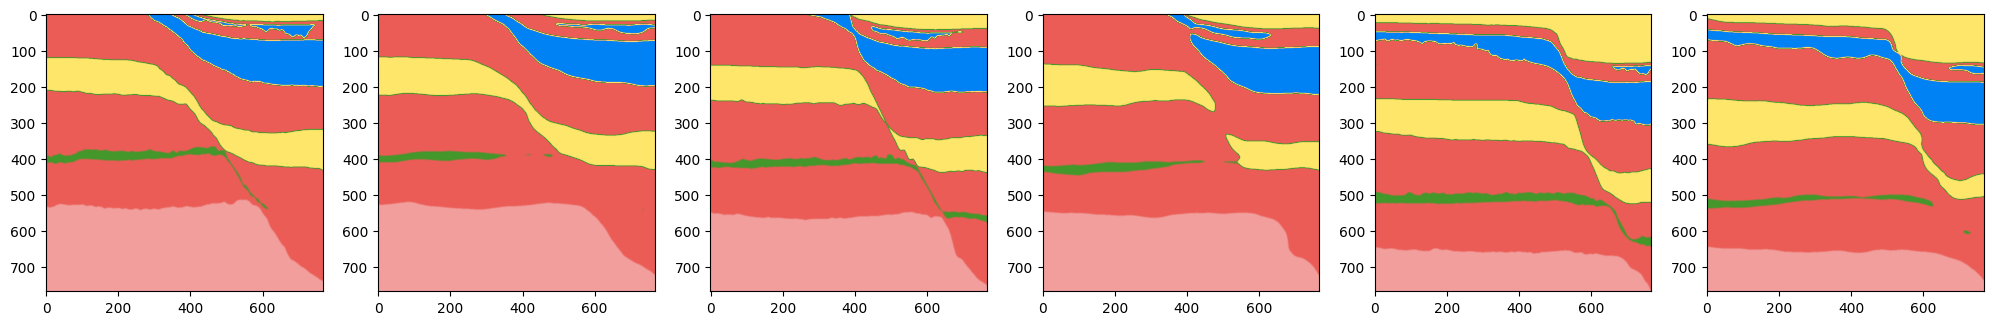

In [11]:
lll = np.zeros((17,768,768)).astype('int32')
for i in range(100,117):
    l = np.fromfile(label_list[i], np.float32).reshape([768,768])-1
    l = l.astype('int32')
    lll[i-100] = l
# predall800 = predall
plt.subplot(1,6,1)
show_image(lll[0],cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,2)
show_image(predall[0], cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,3)
show_image(lll[5], cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,4)
show_image(predall[5],cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,5)
show_image(lll[15],cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,6)
show_image(predall[15],cmap=cmapl, vmin=0, vmax=5)

In [12]:
pa_base_512,cpa_base_512,mpa_base_512,IoU_base_512,mIoU_base_512 = [],[],[],[],[]
metricall = SegmentationMetric(6)  # 2表示有2个分类，有几个分类就填几
for i in range(17):
    histall = metricall.addBatch(predall[i].astype('int64'), lll[i])
    pa_base_512.append(metricall.pixelAccuracy())
    cpa_base_512.append(metricall.classPixelAccuracy())
    mpa_base_512.append(metricall.meanPixelAccuracy())
    IoU_base_512.append(metricall.IntersectionOverUnion())
    mIoU_base_512.append(metricall.meanIntersectionOverUnion())

/usr/users/seismofoundation/ma_yuh/code/SFModel/SFM-Finetune/Application/../util/metrics.py:31: RuntimeWarning: invalid value encountered in divide
  classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
/usr/users/seismofoundation/ma_yuh/code/SFModel/SFM-Finetune/Application/../util/metrics.py:49: RuntimeWarning: invalid value encountered in divide
  IoU = intersection / union  # 返回列表，其值为各个类别的IoU


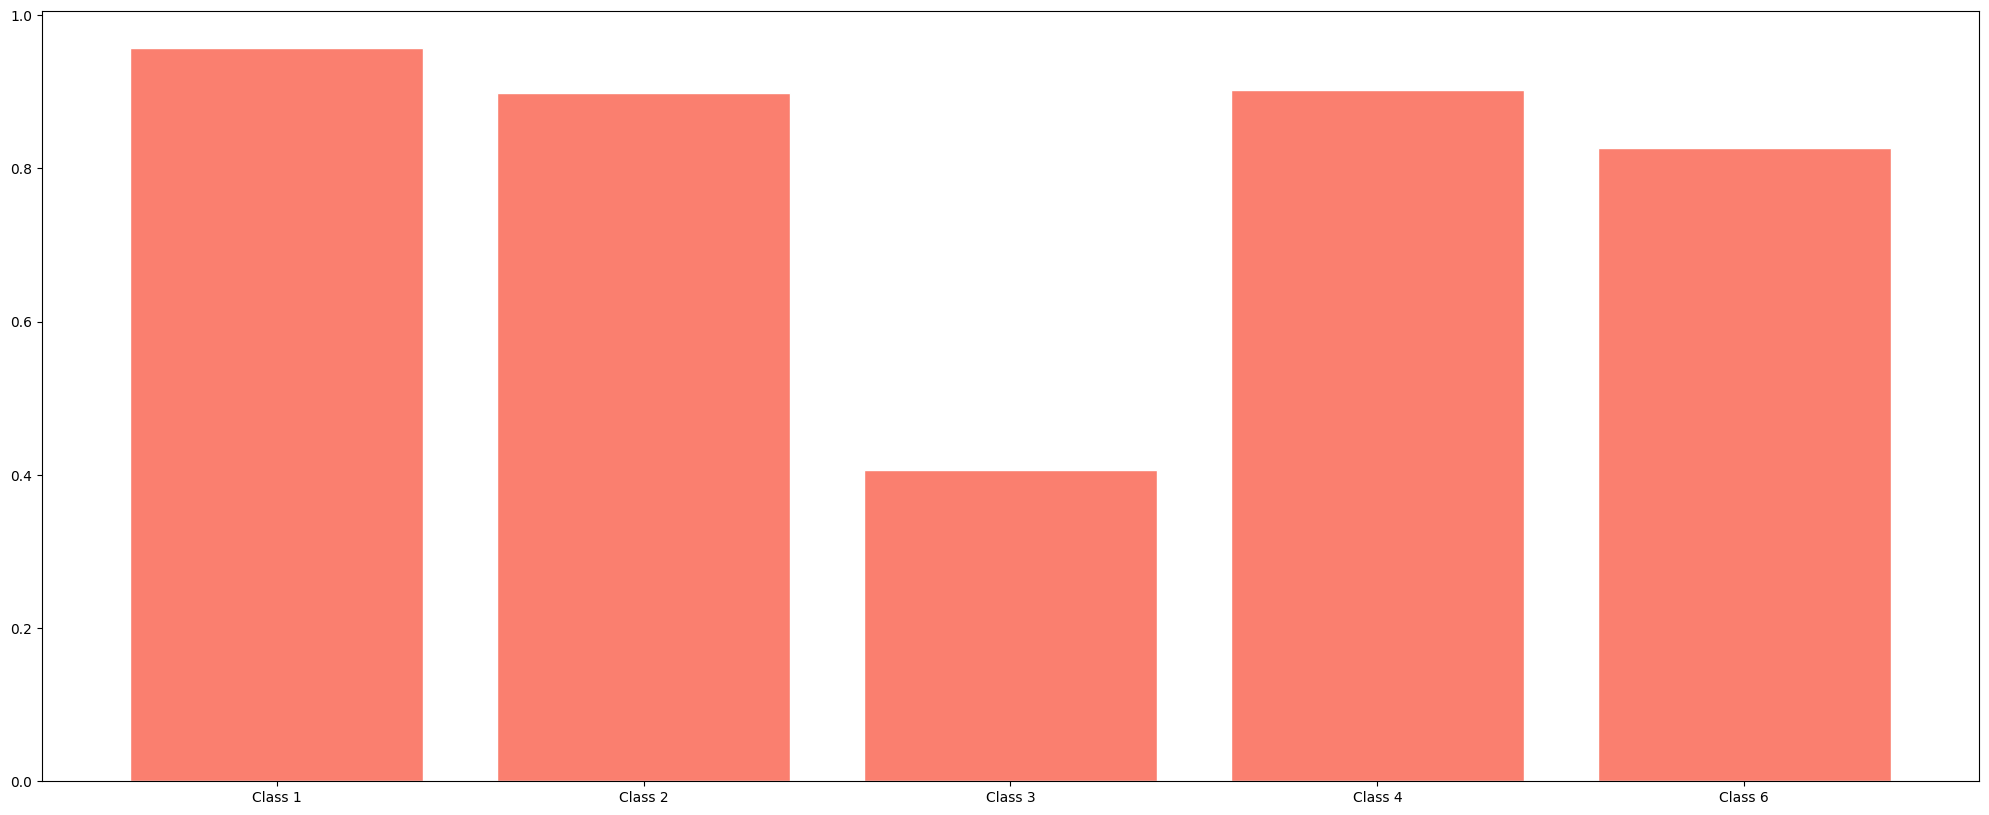

In [13]:
IoU = np.delete(np.mean(IoU_base_512,axis=0),4)
plt.bar(np.arange(5),IoU, color='#FA7F6F', edgecolor='white', label='SFM #512')
plt.xticks(np.arange(5),['Class 1','Class 2','Class 3','Class 4','Class 6'])
plt.show()